# Lab 13: In Lab Exercise
## st121411

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Sample from p_data(x):

def sample_pdata(m):
    means_gt = [ [1,10], [10,1], [10,10] ]
    sigmas_gt = [ np.matrix([[1, 0],[0, 1]]), np.matrix([[4,0],[0,1]]),
                  np.matrix([[1,0],[0,4]]) ]
    phi_gt = [ 0.2, 0.2, 0.6 ]
    n = len(means_gt[0])
    k = len(phi_gt)
    Z = [0]*m
    X = np.zeros((m,n))
    # Generate m samples from multinomial distribution using phi_gt
    z_vectors = np.random.multinomial(1, phi_gt, size=m)  # Result: binary matrix of size (m x k)
    for i in range(m):
        # Convert one-hot representation z_vectors[i,:] to an index
        Z[i] = np.where(z_vectors[i,:] == 1)[0][0]
        # Grab ground truth mean mu_{z^i}
        mu = means_gt[Z[i]]                
        # Grab ground truth covariance Sigma_{z^i}
        sigma = sigmas_gt[Z[i]]
        # Sample a 2D point from mu, sigma
        X[i,:] = np.random.multivariate_normal(mu,sigma,1)
    return X


Let's generate a sample from this ground truth distribution:

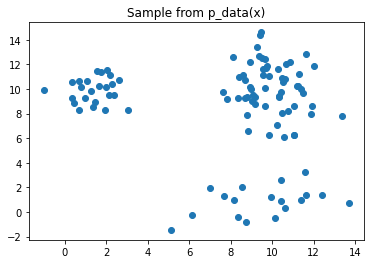

In [2]:
X = sample_pdata(100)

plt.scatter(X[:,0],X[:,1])
plt.title('Sample from p_data(x)')
plt.show()

Next we need a function to sample from the noise distribution:

In [3]:
def sample_noise(m, n):
    return 30*(np.random.randn(m,n))

Let's get a sample from the noise distribution:

(100, 3)


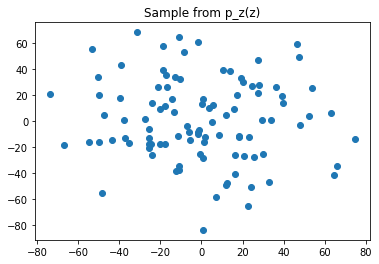

In [4]:
Z = sample_noise(100, 3)

print(Z.shape)

plt.scatter(Z[:,0],Z[:,1])
plt.title('Sample from p_z(z)')
plt.show()

Next, let's define a discriminator and generator:

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GeneratorNet(nn.Module):
    def __init__(self):
        super(GeneratorNet, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(10, 100)
        # Second fully connected layer
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(20,20)
        self.fc4 = nn.Linear(10,10)
        self.fc5 = nn.Linear(10,10)
        self.output = nn.Linear(100, 2)
    
    def forward(self, x):
        # Pass data through fc1
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x)
#         x = self.fc3(x)
#         x = F.relu(x)
#         x = self.fc4(x)
#         x = F.relu(x)
#         x = self.fc5(x)
#        x = F.relu(x)
        output = self.output(x)
        return output
    
class DiscriminatorNet(nn.Module):
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(2, 20)
        # Second fully connected layer
        self.fc2 = nn.Linear(20,20)
        self.fc3 = nn.Linear(20,20)
        self.fc4 = nn.Linear(20,20)
        self.output = nn.Linear(20, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.output(x)
        return F.sigmoid(x)
        

In [6]:
from IPython.display import clear_output
from torch import optim
%matplotlib inline

num_iters = 10000
num_minibatches_discriminator = 1

n = 10

G = GeneratorNet().cuda()
D = DiscriminatorNet().cuda()

D_optimizer = optim.Adam(D.parameters(), lr=0.001)
G_optimizer = optim.Adam(G.parameters(), lr=0.001)
loss = nn.BCELoss()

# for number of training iterations

d_losses = []
g_losses = []

def do_plot(d_losses, g_losses, generated):
    generated = generated.detach().numpy()
    fig,ax = plt.subplots(1,2,figsize=(20,10))
    clear_output(wait=True)
    ax[0].plot(d_losses, label='Discriminator',alpha=0.5)
    ax[0].plot(g_losses, label='Generator',alpha=0.5)
    ax[0].set_title('GAN loss')
    ax[0].legend()
    
    ax[1].scatter(generated[:,0], generated[:,1])
    ax[1].set_xlim([-2,20])
    ax[1].set_ylim([-2,20])
    plt.show()

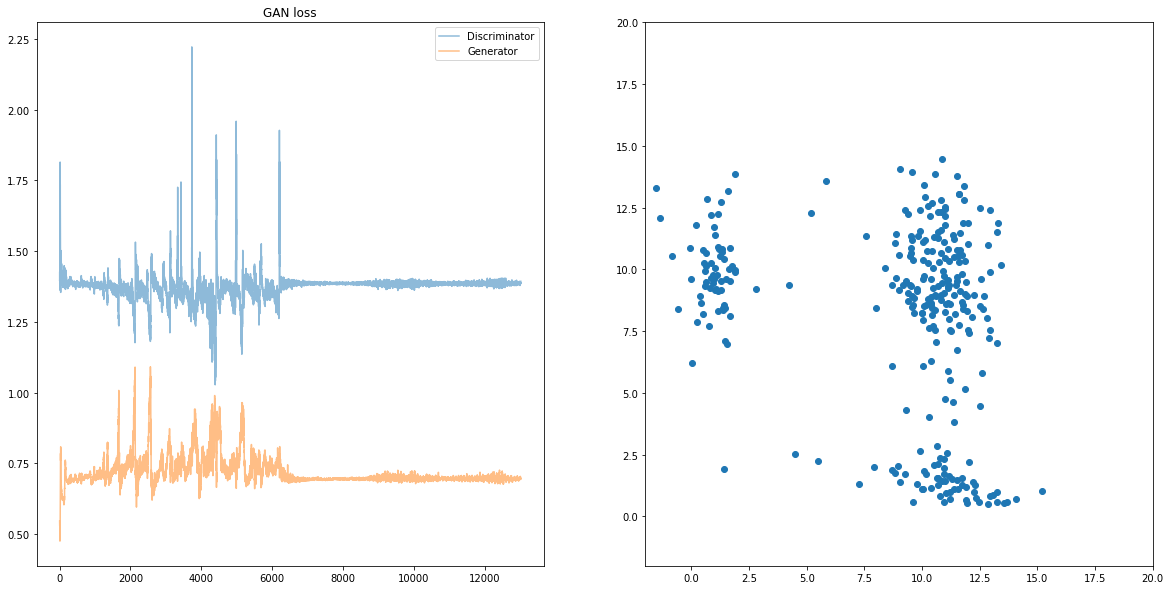

KeyboardInterrupt: 

In [7]:
G.train()
D.train()

num_iters = 30000
minibatch_size = 300

for iter in range(num_iters):
    
    # Train discriminator for num_minibatches_discriminator minibatches

    d_loss = 0
    for discriminator_iter in range(num_minibatches_discriminator):
        D.zero_grad()
        D_optimizer.zero_grad()
        x = torch.tensor(sample_pdata(minibatch_size)).float().cuda()
        z = torch.tensor(sample_noise(minibatch_size, n)).float().cuda()
        xhat = G(z)
        decisions_real = D(x)
        real_targets = torch.ones(minibatch_size, 1).cuda()
        error_real = loss(decisions_real, real_targets)
        error_real.backward()
        decisions_fake = D(xhat)
        fake_targets = torch.zeros(minibatch_size, 1).cuda()
        error_fake = loss(decisions_fake, fake_targets)
        error_fake.backward()
        D_optimizer.step()
        d_loss += error_real + error_fake

    # Train generator on one minibatch
    
    G.zero_grad()
    D.zero_grad()
    G_optimizer.zero_grad()
    z = torch.tensor(sample_noise(minibatch_size, n)).float().cuda()
    xhat = G(z)
    decisions_fake = D(xhat)
    fake_targets = torch.ones(minibatch_size, 1).cuda()
    g_loss = loss(decisions_fake, fake_targets)
    g_loss.backward()
    G_optimizer.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())
    
    if iter % 30 == 0:
        do_plot(d_losses, g_losses, xhat.cpu())

In [8]:
G.eval()
z = torch.tensor(sample_noise(1000, n)).float().cuda()
xhat = G(z)
xhat = xhat.cpu().detach().numpy()

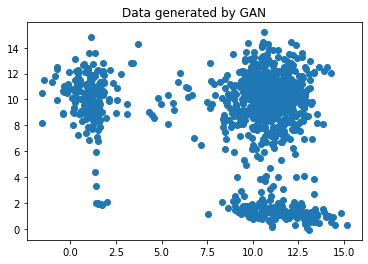

In [9]:
plt.scatter(xhat[:,0],xhat[:,1])
plt.title('Data generated by GAN')
plt.show()

By increasing the variance as well as increasing the dimension of the noise vector and also heavily regularizing the model. The generator was able to create 3 blobs of data. Although the result is satisfactory, if we had the prior knowledge that each cluster is normally distributed, using something like GMM would probably perform better. Nonetheless, this exercise was really interesting!